In [17]:
from google.colab import files
uploaded = files.upload()


Saving hotel_bookings.csv to hotel_bookings (1).csv


In [18]:
!pip install shap xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier


In [19]:
df = pd.read_csv('hotel_bookings.csv')
df.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [20]:
# Checking for nulls
df.isnull().sum()


,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [21]:
# Fill missing values
df['children'].fillna(0, inplace=True)
df['agent'].fillna(0, inplace=True)
df['company'].fillna(0, inplace=True)


/tmp/ipython-input-3309408991.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['children'].fillna(0, inplace=True)
/tmp/ipython-input-3309408991.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [22]:
# Drop irrelevant columns
df.drop(['reservation_status_date', 'reservation_status'], axis=1, inplace=True)


is_canceled
0    0.629584
1    0.370416
Name: proportion, dtype: float64


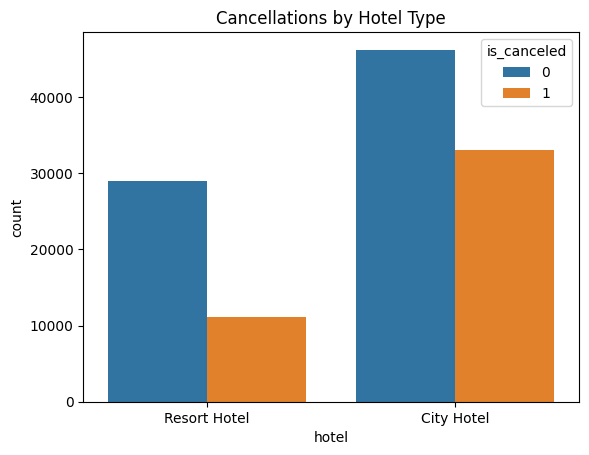

In [23]:
# Cancellation rate
cancel_rate = df['is_canceled'].value_counts(normalize=True)
print(cancel_rate)

# Cancellation by hotel type
sns.countplot(data=df, x='hotel', hue='is_canceled')
plt.title("Cancellations by Hotel Type")
plt.show()


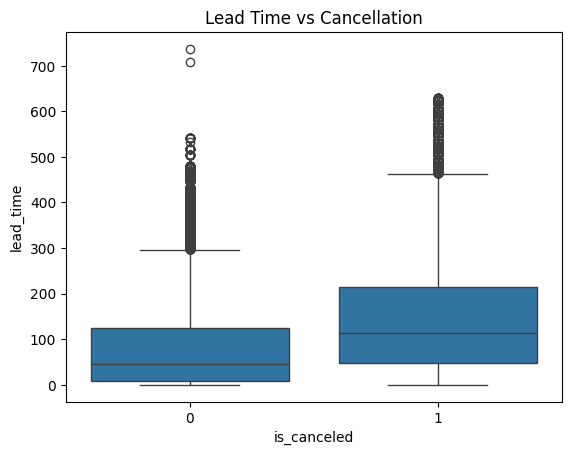

In [24]:
# Lead time vs cancellation
sns.boxplot(data=df, x='is_canceled', y='lead_time')
plt.title("Lead Time vs Cancellation")
plt.show()


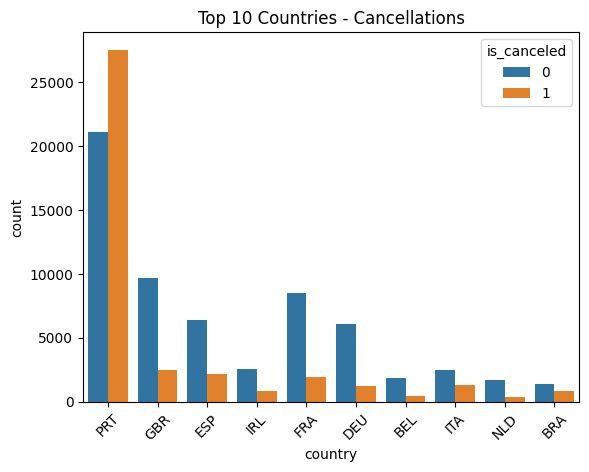

In [25]:
# Country-wise cancellations
top_countries = df['country'].value_counts().head(10).index
sns.countplot(data=df[df['country'].isin(top_countries)], x='country', hue='is_canceled')
plt.title("Top 10 Countries - Cancellations")
plt.xticks(rotation=45)
plt.show()


In [26]:
# Encoding categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Adding total guests
df_encoded['total_guests'] = df_encoded['adults'] + df_encoded['children'] + df_encoded['babies']


In [27]:
X = df_encoded.drop(['is_canceled'], axis=1)
y = df_encoded['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:53:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.89      0.92      0.91     14907
           1       0.86      0.81      0.84      8971

    accuracy                           0.88     23878
   macro avg       0.88      0.87      0.87     23878
weighted avg       0.88      0.88      0.88     23878

ROC AUC Score: 0.8686166497733874


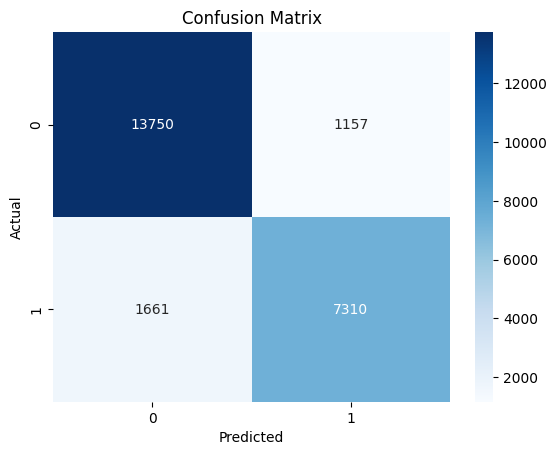

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


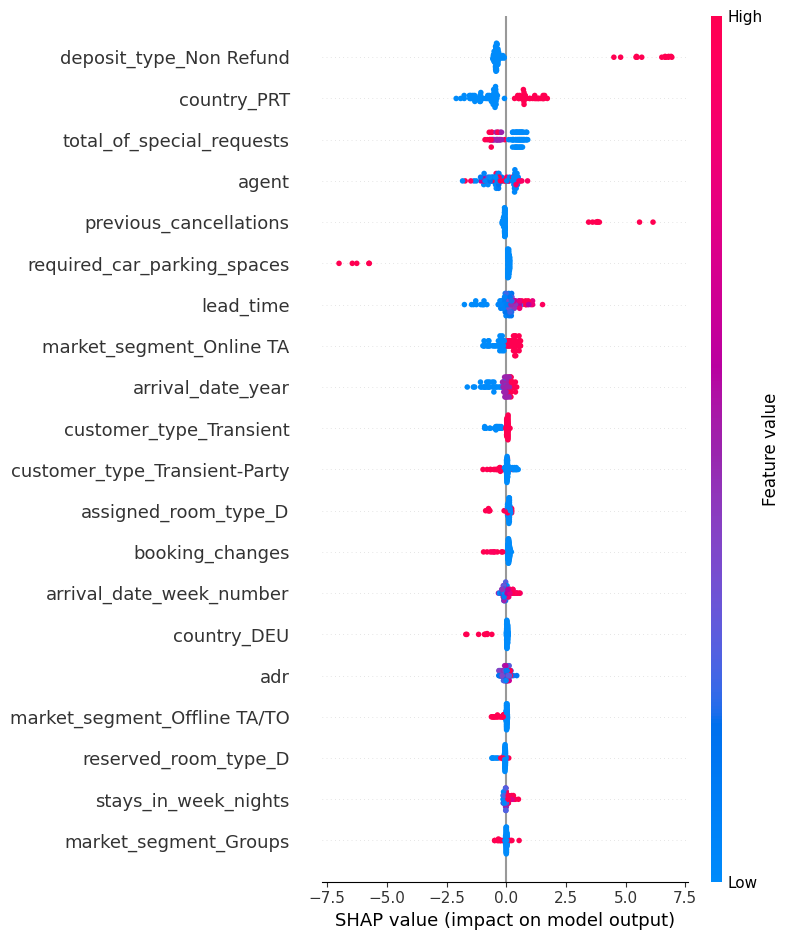

In [30]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test[:100])

shap.summary_plot(shap_values, X_test[:100])


In [31]:
## 💡 Business Insights

##Bookings with long lead times are more likely to cancel.
##City hotels have higher cancellation rates than resort hotels.
##Repeat guests are far less likely to cancel.
##High ADR (average daily rate) bookings show higher cancellation tendency.
##Recommend tighter policies for high-ADR, long-lead bookings.
